In [1]:
import sys, os, pygmt, importlib, re, time
mod_path = '/home/581/da1339/AFIM/src/AFIM/src'
sys.path.insert(0, mod_path)
from sea_ice_toolbox        import SeaIceToolbox, SeaIceToolboxManager
from pathlib                import Path
from tqdm                   import tqdm
from IPython.display        import Image, HTML, Video
import numpy                as np
import pandas               as pd
import xarray               as xr
import matplotlib.pyplot    as plt

In [ ]:
P_log       = Path(Path.home(), "logs", "manager_test.log")
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)

In [ ]:

sim_tools        = SI_tool_mgr.get_toolbox("gi-nil-def", dt0_str="1994-01-01", dtN_str="1999-12-31")
FI_raw, CICE_org = sim_tools.load_processed_cice( zarr_CICE=True )

In [ ]:
D_search  = Path(Path.home(),"seaice","OSI_SAF","ice_drift_455m",)
F_search  = f"ispd_diffs_pygmt_nn_elps-min_199*.nc"
P_found   = sorted(D_search.rglob(F_search))
ispd_diff = xr.open_mfdataset(P_found)
print(ispd_diff)

In [31]:
# Filter for JJA/S
ds_jjas = ispd_diff.sel(time=ispd_diff.time.dt.month.isin([6, 7, 8, 9]))

# Create weekly means
weekly = ds_jjas.resample(time="7D").mean()

# Mask from observed weekly ice speed
valid_mask = np.isfinite(weekly['ispd_obs'])

# Masked speeds
obs_mean  = weekly['ispd_obs'].where(valid_mask).mean(dim=["ny", "nx"])
cice_mean = weekly['ispd_CICE'].where(valid_mask).mean(dim=["ny", "nx"])
aom2_mean = weekly['ispd_AOM2'].where(valid_mask).mean(dim=["ny", "nx"])

# Differences
bias_cice = cice_mean - obs_mean
bias_aom2 = aom2_mean - obs_mean

# Optionally: assemble into one dataset
weekly_bias = xr.Dataset({
    "obs_mean": obs_mean,
    "cice_mean": cice_mean,
    "aom2_mean": aom2_mean,
    "bias_cice": bias_cice,
    "bias_aom2": bias_aom2
})
# 1. Restrict to weeks in June–September
bias_jjas = weekly_bias.sel(time=weekly_bias.time.dt.month.isin([6, 7, 8, 9]))

# 2. Extract week-of-year
weekofyear = bias_jjas['time'].dt.isocalendar().week
bias_jjas = bias_jjas.assign_coords(week=weekofyear)

# 3. Group by week and average across years
weekly_clim = bias_jjas.groupby('week').mean('time')
weekly_std  = bias_jjas.groupby('week').std('time')

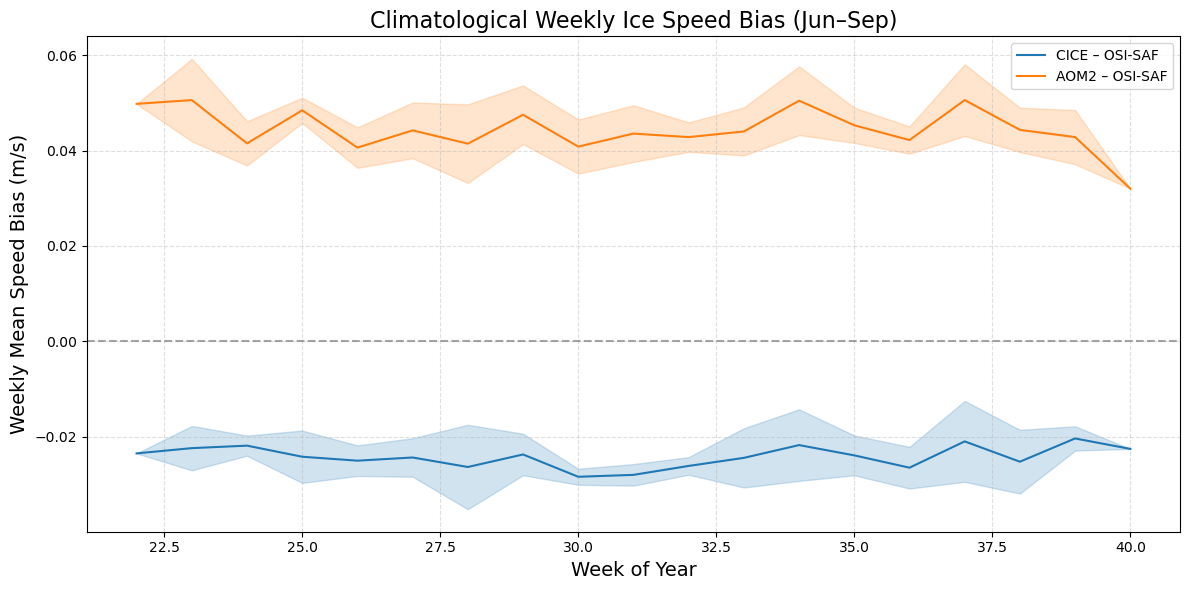

In [33]:

plt.figure(figsize=(12, 6))

plt.plot(weekly_clim['week'], weekly_clim['bias_cice'], label="CICE – OSI-SAF", color="tab:blue")
plt.fill_between(weekly_clim['week'], 
                 weekly_clim['bias_cice'] - weekly_std['bias_cice'],
                 weekly_clim['bias_cice'] + weekly_std['bias_cice'],
                 color="tab:blue", alpha=0.2)

plt.plot(weekly_clim['week'], weekly_clim['bias_aom2'], label="AOM2 – OSI-SAF", color="tab:orange")
plt.fill_between(weekly_clim['week'], 
                 weekly_clim['bias_aom2'] - weekly_std['bias_aom2'],
                 weekly_clim['bias_aom2'] + weekly_std['bias_aom2'],
                 color="tab:orange", alpha=0.2)

plt.axhline(0, ls="--", color="gray", alpha=0.7)
plt.xlabel("Week of Year", fontsize=14)
plt.ylabel("Weekly Mean Speed Bias (m/s)", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()


In [ ]:
daily_mean_obs  = ispd_diff['ispd_obs'].mean(dim=["ny", "nx"])
daily_mean_CICE = ispd_diff['ispd_CICE'].mean(dim=["ny", "nx"])
daily_mean_AOM2 = ispd_diff['ispd_AOM2'].mean(dim=["ny", "nx"])

plt.figure(figsize=(18, 6))
plt.plot(ispd_diff['time'], daily_mean_obs , label='OSI-SAF')
plt.plot(ispd_diff['time'], daily_mean_CICE, label='CICE')
plt.plot(ispd_diff['time'], daily_mean_AOM2, label='AOM2')
plt.ylabel("Daily Mean Ice Speed (m/s)")
plt.xlabel("Time")
plt.grid(True)
plt.legend()
plt.tight_layout()